
## Setup Conda Environment:

To set up the Anaconda environment to run this notebook do the following steps:

#### Install Solaris in Anaconda
```
cd TempDir
git clone https://github.com/cosmiq/solaris.git
cd solaris

For GPU install:
conda env create -f environment-gpu.yml
For CPU install:
conda env create -f environment.yml

conda activate solaris
pip install .
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=solaris
jupyter notebook
```
The notebook must be ran in the conda solaris environment.
Select the solaris kernel in Jupter Notebook -> Kernel -> Change Kernel

If you are having trouble with the additional packages below try this while being in the environment.
```
conda activate solaris
which pip
   -> /home/anaconda/envs/solaris/bin/pip
```
Get the directory location for your conda environment then install pip and all other dependencies to that location
```
/home/anaconda/envs/solaris/bin/pip install package_name
```

In [49]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import solaris as sol
from pathlib import Path
import rasterio
import geopandas as gpd
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import skimage
from tqdm.notebook import tqdm
import gdal
import glob
import os
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rio_tiler import main as rt_main
import matplotlib as mpl
from solaris.vector.mask import mask_to_poly_geojson
from solaris.tile.raster_tile import RasterTiler
import shutil
import yaml
import gdal
from sklearn.model_selection import train_test_split
from skimage.morphology import square, dilation
from solaris.eval.iou import calculate_iou
from ipywidgets import FloatProgress
import torch


In [39]:
root = os.getcwd()

images_out = os.path.join(root, 'images_out')
masks_out = os.path.join(root, 'masks_out')

config_dir = os.path.join(root, 'config')
checkpoints = os.path.join(root, 'checkpoints')

images_test_out = os.path.join(root, 'images_test_out')
masks_test_out = os.path.join(root, 'masks_test_out')

images_val_out = os.path.join(root, 'images_val_out')
masks_val_out = os.path.join(root, 'masks_val_out')

geojson_out = os.path.join(root, 'geojson_out')
geojson_test_out = os.path.join(root, 'geojson_test_out')

train1_datasets = os.path.join(root, 'datasets/train_tier_1')
train2_datasets = os.path.join(root, 'datasets/train_tier_2')
test_datasets = os.path.join(root, 'datasets/test')

inference_out = os.path.join(root, 'inference_out')
inference_out_bin = os.path.join(root, 'inference_out_bin')
inference_polygon_dir = os.path.join(root, 'inference_poly_dir')
ground_truth_polygon_dir = os.path.join(root, 'ground_truth_poly')

In [3]:
directories = [ground_truth_polygon_dir, inference_polygon_dir, inference_out, inference_out_bin, images_out, masks_out, geojson_out, images_test_out, masks_test_out, geojson_test_out, config_dir, checkpoints]

for directory in directories:
    shutil.rmtree(directory, ignore_errors=True)
    os.makedirs(directory)
    file_name = directory + '/.keep'
    f = open(file_name, 'a+')
    f.close


In [40]:
use_train1 = os.path.exists(train1_datasets)
use_train2 = os.path.exists(train2_datasets)
use_test = os.path.exists(test_datasets)



In [5]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
    x,y,z = xyz
    tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
    if display: 
        plt.imshow(np.moveaxis(tile,0,2))
        plt.show()
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.tif',np.moveaxis(tile,0,2), check_contrast=False) 

def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False, greyscale=True):
    x,y,z = xyz
    tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
    
    cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
    cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs='epsg:4326')
    
    fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                             channels=['footprint', 'boundary', 'contact'],
                                             affine_obj=tfm, shape=(tile_size,tile_size),
                                             boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
    if display: plt.imshow(fbc_mask); plt.show()
  
    if greyscale:
        skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.tif',fbc_mask[:,:,0], check_contrast=False) 
    else:
        skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.tif',fbc_mask, check_contrast=False) 

def save_area_id_images(geojson_dir, area = 'acc', img_id = 'ca041a', label_id='ca041a-labels', zoom_level = 19, tile_size = 512):
    curdir = os.getcwd()
    # The item
    one_item = cols[area].get_item(id=img_id)
    tif_url = one_item.assets['image'].href

    # Load labels shapefile
    lab = cols[area].get_item(id=label_id)
    gdf = gpd.read_file(lab.make_asset_hrefs_absolute().assets['labels'].href)
    # get the geometries from the geodataframe
    all_polys = gdf.geometry
    # Get outlines as polygons
    if len(one_item.to_dict()['geometry']['coordinates'][0]) > 1:
        polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0])
    else:
        polygon_geom = Polygon(one_item.to_dict()['geometry']['coordinates'][0][0])
    polygon = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polygon_geom])   
    os.chdir(geojson_dir)

    # Tile at zoom_level
    polygon['geometry'].to_file(img_id + '.geojson', driver='GeoJSON')
    !cat {img_id}.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > {img_id}{zoom_level}tiles.geojson

    # Load tiles
    tiles = gpd.read_file(f'{img_id}{zoom_level}tiles.geojson')
    os.chdir(curdir)

    # Add a convenience column
    tiles['xyz'] = tiles.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
    tiles['xyz'] = [[int(q) for q in p] for p in tiles['xyz']]

    # IMG URL
    tif_url = one_item.assets['image'].href

    # Sometimes it's just ./id.tif - add full path (should maybe use make_asset_hrefs_absolute instead!!)
    if tif_url.startswith("./"):
        tif_url = '/'.join(one_item.to_dict()['links'][1]['href'].split("/")[:-1])+tif_url[1:]

    print("TIF URL:", tif_url)

    print("Number of tiles:", len(tiles))

    # Loop through tiles, downloading and saving
    for idx in tqdm(range(len(tiles))):
        try:
            tile, mask = rt_main.tile(tif_url, *tiles.iloc[idx]['xyz'], tilesize=tile_size)
            tile_poly = tiles.iloc[idx]['geometry']

            # get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
            tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 

            # crop geometries to what overlaps our tile polygon bounds
            cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
            cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs='epsg:4326')

            # burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
            fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                                    channels=['footprint', 'boundary', 'contact'],
                                                    affine_obj=tfm, shape=(tile_size,tile_size),
                                                    boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

            save_tile_img(tif_url, tiles.iloc[idx]['xyz'], tile_size, save_path=img_path, prefix=f'{area}_{img_id}_{idx}_', display=False)
            save_tile_mask(all_polys, tile_poly, tiles.iloc[idx]['xyz'], tile_size, save_path=mask_path,prefix=f'{area}_{img_id}_{idx}_', display=False)
        except:
            print('Tile skipped out of bounds')

In [6]:
if use_train1:
    train1_cat = Catalog.from_file(os.path.join(train1_datasets, 'catalog.json'))
    cols = {cols.id:cols for cols in train1_cat.get_children()}
    for area, catalogs, items in train1_cat.walk():
        if area.id == 'nia':
            for idx, img in enumerate(items):
                img_path = images_out
                mask_path = masks_out
                if idx % 2 == 0:
                    save_area_id_images(geojson_out, area = area.id, img_id = img.id, label_id=img.id + '-labels', zoom_level = 19, tile_size = 512)


TIF URL: /home/coultonf/cmpt733/datasets/train_tier_1/nia/825a50/825a50.tif
Number of tiles: 160


In [7]:
if use_train2:
    train2_cat = Catalog.from_file(os.path.join(train2_datasets, 'catalog.json'))
    cols = {cols.id:cols for cols in train2_cat.get_children()}
    for area, catalogs, items in train2_cat.walk():
        for idx, img in enumerate(items):
            img_path = images_out
            mask_path = masks_out
            if idx % 2 == 0:
                save_area_id_images(geojson_out, area = 'dar', img_id = '353093', label_id='353093' + '-labels', zoom_level = 19, tile_size = 512)

In [8]:
if use_test:
    test_cat = Catalog.from_file(os.path.join(test_datasets, 'catalog.json'))
    cols = {cols.id:cols for cols in test_cat.get_children()}
    for area, catalogs, items in test_cat.walk():
        for idx, img in enumerate(items):
            img_path = images_test_out
            mask_path = masks_test_out
            if idx % 2 == 0:
                save_area_id_images(geojson_test_out, area = area.id, img_id = img.id, label_id=img.id + '-labels', zoom_level = 19, tile_size = 512)

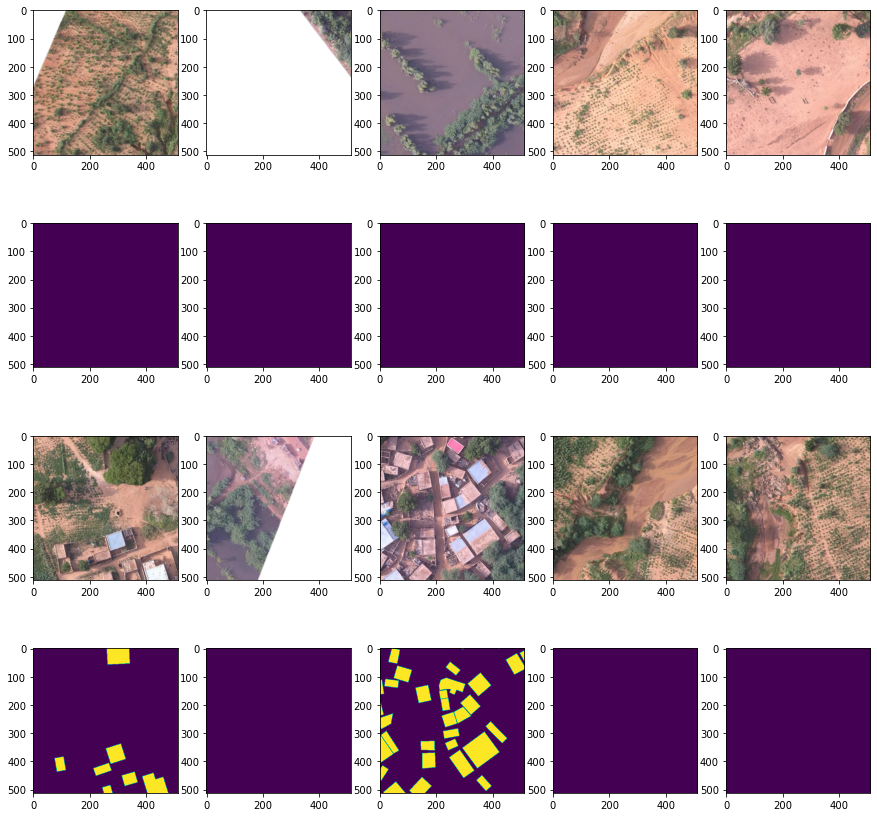

In [41]:
plt.figure(figsize = (15,15))

i=1
num_rows = 2
num_cols = 5
for x in range(num_rows):
    images = []
    idx_start = (num_cols+1)*x
    idx_end = (num_cols+1)*x+num_cols
    for file in [f for f in os.listdir(images_out) if not f.startswith('.')][idx_start:idx_end]:
        images.append(file)
        img=mpl.image.imread(os.path.join(images_out, file))
        plt.subplot(num_rows*2, num_cols, i)
        plt.imshow(img)
        i = i + 1

    for file in images:
        img=mpl.image.imread(os.path.join(masks_out, file[:-4] + '_mask.tif'))
        plt.subplot(num_rows*2, num_cols, i)
        plt.imshow(img)
        i = i + 1


In [42]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

if use_train1 or use_train2:
    os.chdir(root)
    all_images = [f for f in os.listdir(images_out) if not f.startswith('.')]
    df_all = pd.DataFrame(all_images, columns=['image_id'])
    train_images, test_images = train_test_split(df_all)
    
    df_train = pd.DataFrame(train_images, columns=['image_id'])
    df = df_train['image_id'].str.split('.', n=1, expand=True)
    df_train['image'] = images_out + '/' + df_train['image_id']
    df_train['label_id'] = df[0] + '_mask.' + df[1]
    df_train['label'] = masks_out + '/' + df[0] + '_mask.' + df[1]
    df_train_csv = df_train.drop(columns=['image_id', 'label_id'])
    df_train_csv.to_csv(os.path.join(config_dir, 'df_train.csv'))
    
    df_test = pd.DataFrame(test_images, columns=['image_id'])
    df = df_test['image_id'].str.split('.', n=1, expand=True)
    df_test['image'] = images_test_out + '/' + df_test['image_id']
    df_test['label_id'] = df[0] + '_mask.' + df[1]
    df_test['label'] = masks_test_out + '/' + df[0] + '_mask.' + df[1]
    df_test_csv = df_test.drop(columns=['image_id', 'label_id'])
    df_test_csv.to_csv(os.path.join(config_dir, 'df_test.csv'))
    
    for idx, item in tqdm(df_test.iterrows()):
        shutil.move(os.path.join(images_out, item.image_id), os.path.join(images_test_out, item.image_id))
        shutil.move(os.path.join(masks_out, item.label_id), os.path.join(masks_test_out, item.label_id))

In [43]:
M1=[]
M2=[]
M3=[]
S1=[]
S2=[]
S3=[]


driver = gdal.GetDriverByName("GTiff")
os.chdir(images_out)
images=glob.glob("*.tif")
for file in tqdm(images):
    band = gdal.Open(file)
    if band != None:
        band = band.ReadAsArray()
        M1.append(np.mean(band[0,:,:]))
        M2.append(np.mean(band[1,:,:]))
        M3.append(np.mean(band[2,:,:]))
        S1.append(np.std(band[0,:,:]))
        S2.append(np.std(band[1,:,:]))
        S3.append(np.std(band[2,:,:]))

os.chdir(images_test_out)
images=glob.glob("*.tif")
for file in tqdm(images):
    band = gdal.Open(file)
    if band != None:
        band = band.ReadAsArray()
        M1.append(np.mean(band[0,:,:]))
        M2.append(np.mean(band[1,:,:]))
        M3.append(np.mean(band[2,:,:]))
        S1.append(np.std(band[0,:,:]))
        S2.append(np.std(band[1,:,:]))
        S3.append(np.std(band[2,:,:]))

os.chdir(root)
m1=(np.mean(M1)/255).item()
m2=(np.mean(M2)/255).item()
m3=(np.mean(M3)/255).item()
s1=(np.mean(S1)/255).item()
s2=(np.mean(S2)/255).item()
s3=(np.mean(S3)/255).item()

model_yml = os.path.join(root, 'model.yml')
new_model = None
with open(model_yml, 'r') as f:
    data = f.read()
    new_model = yaml.load(data, Loader=yaml.FullLoader)
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][0] = m1
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][1] = m2
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][2] = m3
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][0] = s1
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][1] = s2
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][2] = s3
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][0] = m1
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][1] = m2
    new_model['inference_augmentation']['augmentations']['Normalize']['mean'][2] = m3
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][0] = s1
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][1] = s2
    new_model['inference_augmentation']['augmentations']['Normalize']['std'][2] = s3
    new_model['validation_augmentation']['augmentations']['Normalize']['mean'][0] = m1
    new_model['validation_augmentation']['augmentations']['Normalize']['mean'][1] = m2
    new_model['validation_augmentation']['augmentations']['Normalize']['mean'][2] = m3
    new_model['validation_augmentation']['augmentations']['Normalize']['std'][0] = s1
    new_model['validation_augmentation']['augmentations']['Normalize']['std'][1] = s2
    new_model['validation_augmentation']['augmentations']['Normalize']['std'][2] = s3
with open(model_yml, 'w') as f:
    yaml.dump(new_model, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


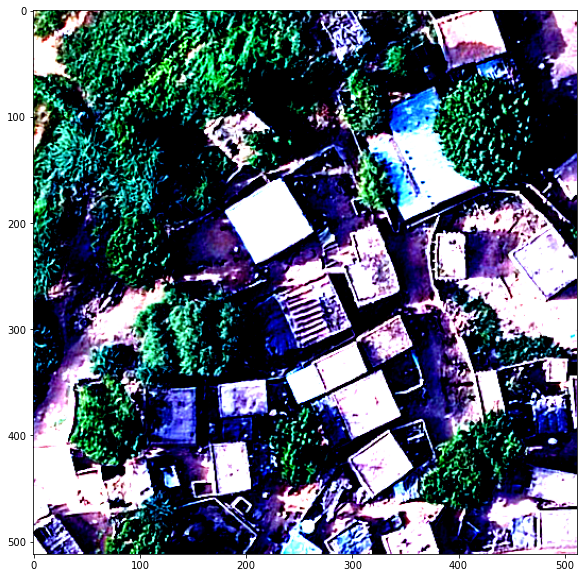

In [56]:
from albumentations import (Normalize, Compose, IAAEmboss)
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)


image = mpl.image.imread(os.path.join(images_out, 'nia_825a50_93_19_265061_242183.tif'))
image = image[:,:,:3]
def augmentations(p=1):
    return Compose([
        Normalize(mean=(m1, m2, m3), 
                std=(s1, s2, s3), 
                max_pixel_value=255.0, 
                always_apply=True, 
                p=1.0),
        IAAEmboss()
    ], p=p)


augment_and_show(augmentations(), image)

Errors related to a corrupt downloaded model can have the pretrained model and weights (.pth) deleted in the following folders as a potential solution.
```
~/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/weights
~/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/zoo
```

In [12]:
os.chdir(root)
config = sol.utils.config.parse('model.yml')
config;

#### Possible Errors

If downloaded model becomes corrupted, delete files for the model and edit the init py file to remove the model from the dictionary.

```
~/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/zoo
~/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/weights
~/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/zoo/__init__.py
```

Out of memory - the batch size parameter in the model.yml file needs to be reduced to accomodate your machines specific memory restricitons. At the same time, if training, it is recommended to increase the batch size until failure to reduce training times.

In [14]:
# device = torch.device('cpu')
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, map_location=device))

In [15]:
trainer = sol.nets.train.Trainer(config)
trainer.train()

Beginning training epoch 0


/home/coultonf/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


    loss at batch 0: 4.490909576416016
    loss at batch 10: 2.940464735031128
    loss at batch 20: 1.7301466464996338
    loss at batch 30: 1.5248582363128662

    Validation loss at epoch 0: 1.8357176780700684

Beginning training epoch 1
    loss at batch 0: 2.5020999908447266
    loss at batch 10: 2.5282883644104004
    loss at batch 20: 1.610403060913086
    loss at batch 30: 0.3482973277568817

    Validation loss at epoch 1: 1.4746366739273071

Beginning training epoch 2
    loss at batch 0: 0.5707808136940002
    loss at batch 10: 1.854736566543579
    loss at batch 20: 1.0540149211883545
    loss at batch 30: 1.0923291444778442

    Validation loss at epoch 2: 1.4614393711090088

Beginning training epoch 3
    loss at batch 0: 0.7413978576660156
    loss at batch 10: 0.3022647798061371
    loss at batch 20: 0.3263813257217407
    loss at batch 30: 0.6649764776229858

    Validation loss at epoch 3: 1.6947462558746338

Beginning training epoch 4
    loss at batch 0: 0.133786350

In [16]:
inf_df = sol.nets.infer.get_infer_df(config)
inferer = sol.nets.infer.Inferer(config)
inferer(inf_df)

/home/coultonf/anaconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/infer.py:23: UserWarning: Because the configuration specifies both training and inference, solaris is switching the model weights path to the training output path.
  warn('Because the configuration specifies both training and '


In [17]:
inference_out_bin = os.path.join(root, 'inference_out_bin')  ## A location to store binarized outputs
inference_polygon_dir = os.path.join(root, 'inference_poly_dir') ## Outputs polygonized
ground_truth_polygon_dir = os.path.join(root, 'ground_truth_poly') ## Ground Truth Outputs polygonized

In [23]:
from solaris.vector.mask import mask_to_poly_geojson
driver = gdal.GetDriverByName("GTiff")

os.chdir(inference_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    band[np.where((band > 0))] = 1
    band[np.where((band <= 0))] = 0
    im_out = driver.Create(os.path.join(inference_out_bin,image),band.shape[1],band.shape[0],1,gdal.GDT_Byte)
    im_out.GetRasterBand(1).WriteArray(band)
    del im_out
    output=os.path.join(inference_polygon_dir,image.split(".")[0]+".geojson")
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')


os.chdir(masks_test_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    output=os.path.join(ground_truth_polygon_dir,image.split(".")[0]+".geojson")
    image=image.split("_mask")[0]+image.split("_mask")[1]
    output=output.split("_mask")[0]+output.split("_mask")[1]
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')


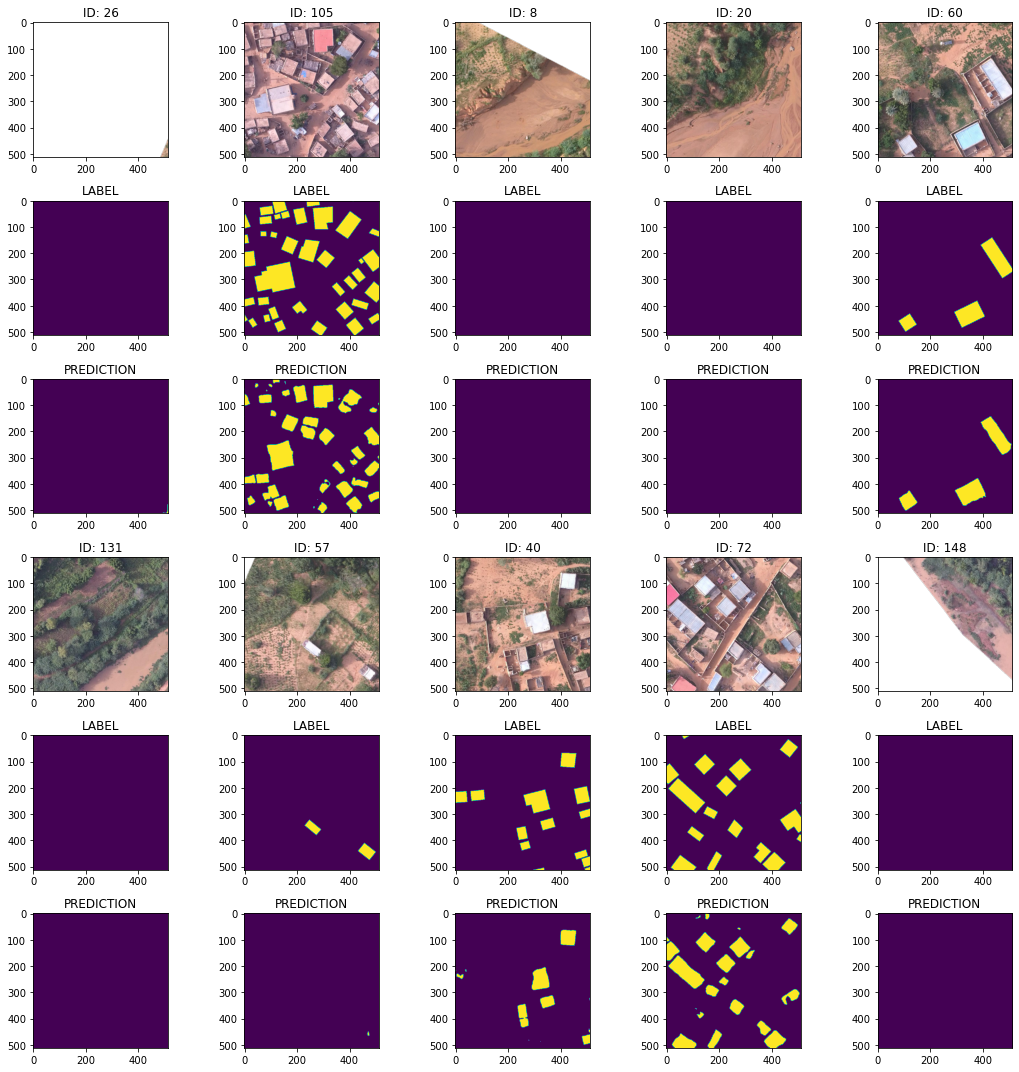

In [24]:
plt.figure(figsize = (15,15))

i=1
num_rows = 2
num_cols = 5
for x in range(num_rows):
    images = []
    idx_start = (num_cols+1)*x
    idx_end = (num_cols+1)*x+num_cols
    for file in [f for f in os.listdir(images_test_out) if not f.startswith('.')][idx_start:idx_end]:
        images.append(file)
        img=mpl.image.imread(os.path.join(images_test_out, file))
        plt.subplot(num_rows*3, num_cols, i)
        plt.title('ID: ' + file.split('_')[2])
        plt.imshow(img)
        i = i + 1

    for file in images:
        img=mpl.image.imread(os.path.join(masks_test_out, file[:-4] + '_mask.tif'))
        plt.subplot(num_rows*3, num_cols, i)
        plt.title('LABEL')
        plt.imshow(img)
        i = i + 1
        
    for file in images:
        img=mpl.image.imread(os.path.join(inference_out_bin, file))
        plt.subplot(num_rows*3, num_cols, i)
        plt.title('PREDICTION')
        plt.imshow(img)
        i = i + 1
plt.tight_layout()

In [20]:

#Wrapper functions for calculate_iou

def precision_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(proposal_polygons_dir)
    search = "*" + file_format
    proposal_geojsons=glob.glob(search)
    for geojson in tqdm(proposal_geojsons):
        ground_truth_poly = os.path.join(groundtruth_polygons_dir,geojson)
        if os.path.exists(ground_truth_poly):
            ground_truth_gdf=gpd.read_file(ground_truth_poly)
            proposal_gdf=gpd.read_file(geojson)
            for index, row in (proposal_gdf.iterrows()):
                iou=calculate_iou(row.geometry, ground_truth_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious

def recall_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(groundtruth_polygons_dir)
    search = "*" + file_format
    gt_geojsons=glob.glob(search)
    for geojson in tqdm(gt_geojsons):
        proposal_poly = os.path.join(proposal_polygons_dir,geojson)
        if os.path.exists(proposal_poly):
            proposal_gdf=gpd.read_file(proposal_poly)
            gt_gdf=gpd.read_file(geojson)
            for index, row in (gt_gdf.iterrows()):
                iou=calculate_iou(row.geometry, proposal_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious
    
def f1_score(precision_ious,recall_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    
    items=[]
    for i in recall_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    recall= np.mean(items)
    
    f1 = 2* precision * recall/(precision + recall)
    return f1

def simple_average_precision(precisions_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    return precision

In [21]:
# Score our results

precision_ious = precision_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
recall_ious = recall_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
print(f1_score(precision_ious,recall_ious,threshold=0.25), "F1 Score@0.25")
print(f1_score(precision_ious,recall_ious,threshold=0.5), "F1 Score@0.5")
print(simple_average_precision(precision_ious,threshold=0.25), "AP@0.25")
print(simple_average_precision(precision_ious,threshold=0.5), "AP@0.5")


0.6281455599747241 F1 Score@0.25
0.5555555555555555 F1 Score@0.5
0.6121495327102804 AP@0.25
0.5373831775700935 AP@0.5


### Data Analysis
How much area of a city is covered with buildings?

What is the building density for a given city?

In [31]:
geojsons = glob.glob(os.path.join(root, inference_polygon_dir, '*.geojson'))

df = pd.DataFrame()
list = []
for gj in geojsons:
    predict = gpd.read_file(os.path.join(root, inference_polygon_dir, gj))
    predict_area = predict.area.sum()
    total_area = 0
    gt_file = os.path.join(root, ground_truth_polygon_dir, gj.split('/')[-1])
    if os.path.exists(gt_file):
        truth = gpd.read_file(gt_file)
        truth_area = truth.area.sum()
    else:
        truth_area = 0
    for file in [f for f in os.listdir(images_test_out) if not f.startswith('.')]:
        total_area = total_area + (512 * 512)
        
    list.append([gj.split('_')[2][4:], 
                 predict_area, 
                 truth_area, 
                 abs(truth_area - predict_area), 
                 total_area,
                 (predict_area/total_area*100)])
    
df = pd.DataFrame(list, columns=['city', 'predicted_area', 'actual_area', 'incorrect_area', 'total_area', 'building_density(%)'])
df.groupby('city').sum()

,predicted_area,actual_area,incorrect_area,total_area,building_density(%)
city,,,,,
nia,300644.0,384913.0,98911.0,220200960,2.867165
